In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

=== Equal-Weighted Portfolio ===
final_value: 1442.1703
sharpe: 1.6512
max_drawdown: -0.5350
win_rate: 0.4747
expectancy: 0.0065

=== Volume-Weighted Portfolio ===
final_value: 1008.8902
sharpe: 0.7424
max_drawdown: -0.5600
win_rate: 0.4747
expectancy: 0.0030


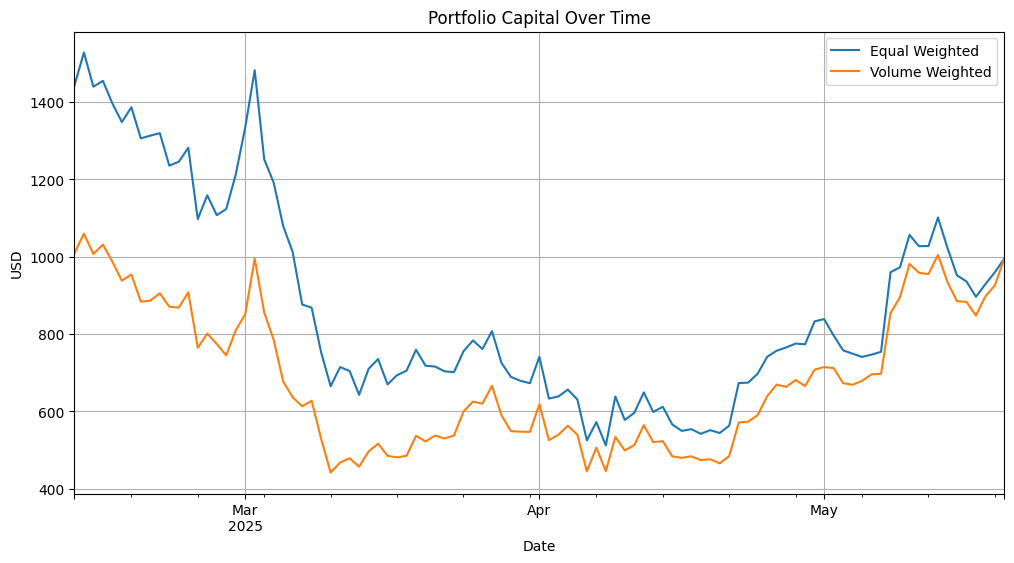

In [5]:
# Load all .csv files in the folder
csv_files = glob.glob("/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index/dataframes/*.csv")
returns = []
closes = []
volumes = []

for file in csv_files:
    token = os.path.splitext(file)[0]  # get token name from file
    df = pd.read_csv(file, index_col=0, parse_dates=True)

    # Rename series for clarity
    returns.append(df['return'].rename(token))
    closes.append(df['close'].rename(token))
    volumes.append(df['volume'].rename(token))

# Combine into unified DataFrames
returns_df = pd.concat(returns, axis=1).dropna()
closes_df = pd.concat(closes, axis=1).dropna()
volumes_df = pd.concat(volumes, axis=1).dropna()

# Ensure alignment of all
returns_df = returns_df.loc[closes_df.index.intersection(volumes_df.index)]
closes_df = closes_df.loc[returns_df.index]
volumes_df = volumes_df.loc[returns_df.index]

# Equal weights
equal_weights = np.repeat(1 / returns_df.shape[1], returns_df.shape[1])

# Volume-based weights using *first-day volume* (or mean volume)
initial_vol = volumes_df.iloc[0]
vol_weights = initial_vol / initial_vol.sum()

# === Backtest Portfolios ===
initial_capital = 1000 # starting with $1000 
equal_port_ret = returns_df @ equal_weights
vol_port_ret = returns_df @ vol_weights

equal_port_value = (1 + equal_port_ret).cumprod() * initial_capital
vol_port_value = (1 + vol_port_ret).cumprod() * initial_capital

# === Metrics Function ===
def portfolio_metrics(port_ret, port_value):
    sharpe = port_ret.mean() / port_ret.std() * np.sqrt(365)
    drawdown = (port_value / port_value.cummax()) - 1
    max_drawdown = drawdown.min()
    win_rate = (port_ret > 0).mean()
    mean_win = port_ret[port_ret > 0].mean()
    mean_loss = port_ret[port_ret < 0].mean()
    loss_rate = 1 - win_rate
    expectancy = mean_win * win_rate + mean_loss * loss_rate

    return {
        'final_value': port_value.iloc[-1],
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'expectancy': expectancy
    }

# Compute and print metrics
equal_metrics = portfolio_metrics(equal_port_ret, equal_port_value)
vol_metrics = portfolio_metrics(vol_port_ret, vol_port_value)

print("=== Equal-Weighted Portfolio ===")
for k, v in equal_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Volume-Weighted Portfolio ===")
for k, v in vol_metrics.items():
    print(f"{k}: {v:.4f}")

# === Plot ===
plt.figure(figsize=(12, 6))
equal_port_value.plot(label="Equal Weighted")
vol_port_value.plot(label="Volume Weighted")
plt.title("Portfolio Capital Over Time")
plt.ylabel("USD")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
folder_path = './dataframes' 

summary_list = []

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        token_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder_path, file), index_col=0)

        df = df.dropna(subset=['return'])

        # Metrics
        days = len(df)
        total_return = (df['close'].iloc[-1] / df['close'].iloc[0]) - 1
        sharpe_ratio = df['return'].mean() / df['return'].std() * np.sqrt(365)
        max_drawdown = df['drawdown'].min()
        win_rate = (df['return'] > 0).mean()

        mean_win = df[df['return'] > 0]['return'].mean()
        mean_loss = df[df['return'] < 0]['return'].mean()
        loss_rate = 1 - win_rate
        expectancy = mean_win * win_rate + mean_loss * loss_rate

        summary_list.append({
            'Token': token_name,
            'No.Days': days,
            'Sharpe': round(sharpe_ratio, 4),
            'Total Return': round(total_return, 4),
            'Max Drawdown': round(max_drawdown, 4),
            'Win Rate': round(win_rate, 4),
            'Expectancy': round(expectancy, 4)
        })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_list)
summary_df = summary_df.sort_values(by='Sharpe', ascending=False).reset_index(drop=True)

# View it
print(summary_df)


     Token  No.Days  Sharpe  Total Return  Max Drawdown  Win Rate  Expectancy
0      SBR       99  3.1364        2.6002       -0.6384    0.6162      0.0247
1  MOODENG       99  1.8183        0.5802       -0.6955    0.5354      0.0098
2   VERTAI       99  1.6033        0.2992       -0.6760    0.5152      0.0110
3      XMW       99  0.9275       -0.0678       -0.7271    0.5354      0.0055
4      SPX       99  0.9043       -0.0284       -0.6441    0.5152      0.0050
5     SERV       99  0.8552       -0.1833       -0.7944    0.4949      0.0055
6  PATRIOT       99  0.6461       -0.3904       -0.8139    0.5152      0.0046
7    WHITE       99  0.5227       -0.7187       -0.9105    0.5859      0.0064
8     VSTR       99 -0.4478       -0.4148       -0.5988    0.5455     -0.0019
9     REKT       99 -1.2584       -0.6005       -0.8801    0.4545     -0.0056


<Axes: xlabel='Sharpe', ylabel='Total Return'>

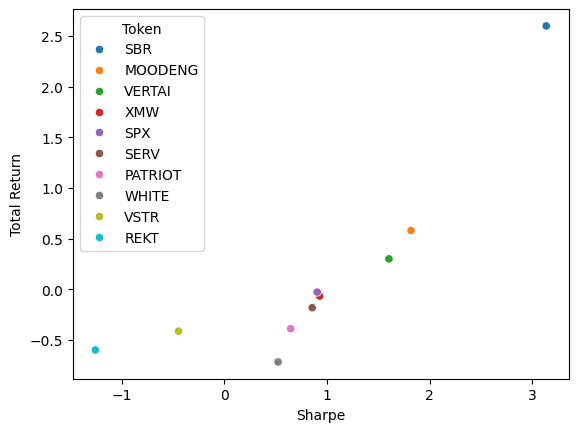

In [8]:
import seaborn as sns
sns.scatterplot(data=summary_df, x='Sharpe', y='Total Return', hue='Token')

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load data
folder_path = './dataframes'
returns = []
closes = []
volumes = []
token_names = []

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        token = file.replace('.csv', '')
        token_names.append(token)
        df = pd.read_csv(os.path.join(folder_path, file), index_col=0, parse_dates=True)
        df = df.dropna(subset=['return'])

        returns.append(df['return'].rename(token))
        closes.append(df['close'].rename(token))
        volumes.append(df['volume'].rename(token))

returns_df = pd.concat(returns, axis=1).dropna()
closes_df = pd.concat(closes, axis=1).dropna()
volumes_df = pd.concat(volumes, axis=1).dropna()

# Align all
index = returns_df.index.intersection(closes_df.index).intersection(volumes_df.index)
returns_df = returns_df.loc[index]
closes_df = closes_df.loc[index]
volumes_df = volumes_df.loc[index]

# === Backtest Function ===
def run_backtest(returns_df, volumes_df, initial_capital=1000):
    equal_weights = np.repeat(1 / returns_df.shape[1], returns_df.shape[1])
    initial_vol = volumes_df.iloc[0]
    vol_weights = initial_vol / initial_vol.sum()

    eq_ret = returns_df @ equal_weights
    vol_ret = returns_df @ vol_weights

    eq_val = (1 + eq_ret).cumprod() * initial_capital
    vol_val = (1 + vol_ret).cumprod() * initial_capital

    return eq_ret, vol_ret, eq_val, vol_val

# === Metrics ===
def portfolio_metrics(port_ret, port_value):
    sharpe = port_ret.mean() / port_ret.std() * np.sqrt(365)
    drawdown = (port_value / port_value.cummax()) - 1
    max_dd = drawdown.min()
    win_rate = (port_ret > 0).mean()
    mean_win = port_ret[port_ret > 0].mean()
    mean_loss = port_ret[port_ret < 0].mean()
    expectancy = mean_win * win_rate + mean_loss * (1 - win_rate)

    return {
        'final_value': port_value.iloc[-1],
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'win_rate': win_rate,
        'expectancy': expectancy
    }

In [14]:
results = {}

for months in [2, 4, 6]:
    days = months * 30  # approx
    sliced_returns = returns_df.iloc[:days]
    sliced_volumes = volumes_df.iloc[:days]

    eq_ret, vol_ret, eq_val, vol_val = run_backtest(sliced_returns, sliced_volumes)

    results[f"{months}M_equal"] = portfolio_metrics(eq_ret, eq_val)
    results[f"{months}M_volume"] = portfolio_metrics(vol_ret, vol_val)


In [15]:
pd.DataFrame(results).T.round(4)

,final_value,sharpe,max_drawdown,win_rate,expectancy
2M_equal,703.8768,-0.8088,-0.5350,0.4333,-0.0031
2M_volume,530.2527,-1.9953,-0.5571,0.4333,-0.0078
4M_equal,1442.1703,1.6512,-0.5350,0.4747,0.0065
4M_volume,1008.8902,0.7424,-0.5600,0.4747,0.0030
6M_equal,1442.1703,1.6512,-0.5350,0.4747,0.0065
6M_volume,1008.8902,0.7424,-0.5600,0.4747,0.0030


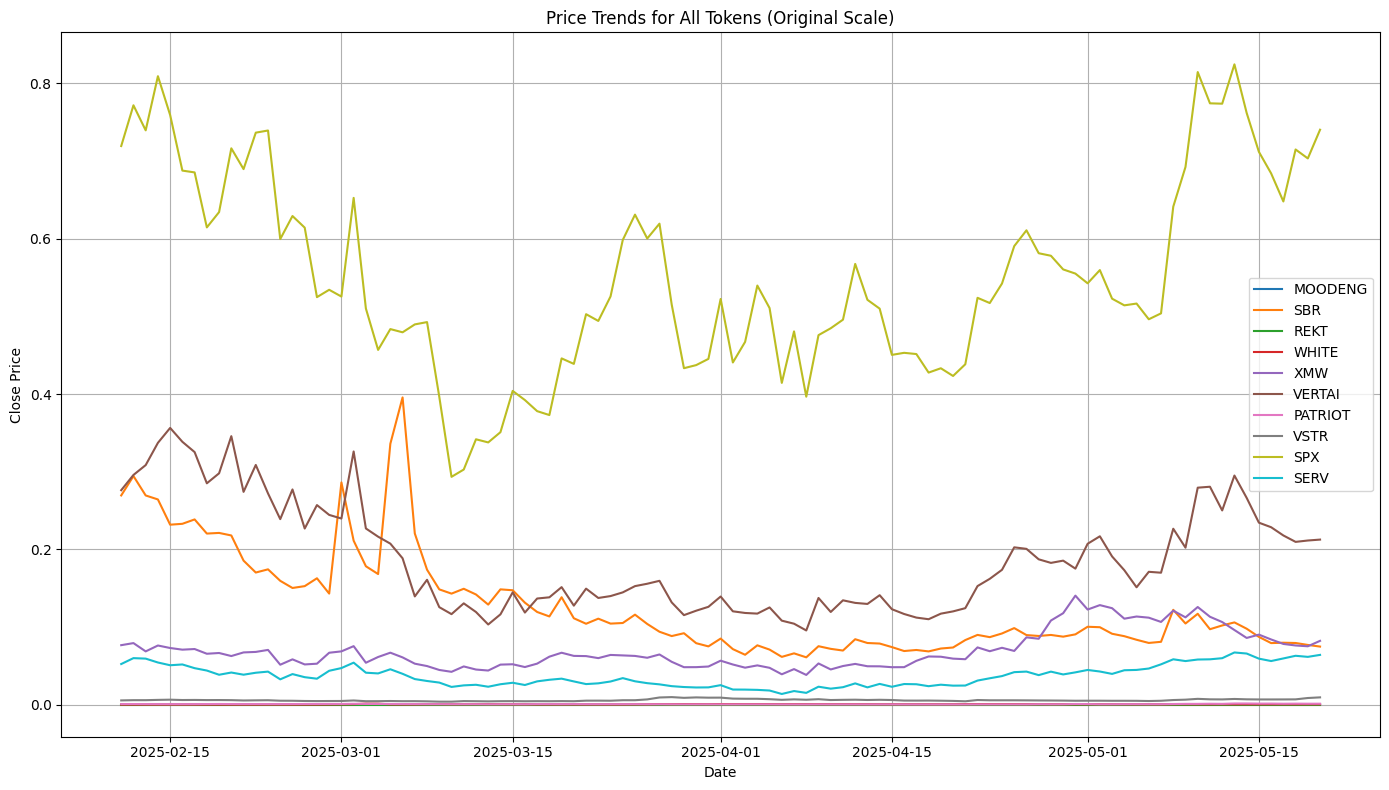

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

folder_path = './dataframes'  # Your token CSVs
plt.figure(figsize=(14, 8))

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        token_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder_path, file), index_col=0, parse_dates=True)
        plt.plot(df.index, df['close'], label=token_name)

plt.title('Price Trends for All Tokens (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
pnl_data = []

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        token_name = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder_path, file), index_col=0)

        # Drop NaNs just in case
        df = df.dropna(subset=['close'])

        # Calculate Total Return (PnL %)
        total_return = (df['close'].iloc[-1] / df['close'].iloc[0]) - 1
        pnl_data.append({'Token': token_name, 'Total Return (%)': round(total_return * 100, 2)})

# Create and sort PnL DataFrame
pnl_df = pd.DataFrame(pnl_data)
pnl_df = pnl_df.sort_values(by='Total Return (%)', ascending=False).reset_index(drop=True)

print(pnl_df)

     Token  Total Return (%)
0      SBR            260.02
1  MOODENG             58.02
2   VERTAI             29.92
3      SPX             -2.84
4      XMW             -6.78
5     SERV            -18.33
6  PATRIOT            -39.04
7     VSTR            -41.48
8     REKT            -60.05
9    WHITE            -71.87


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_78186/4267903038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Total Return (%)', data=pnl_df, palette='coolwarm')


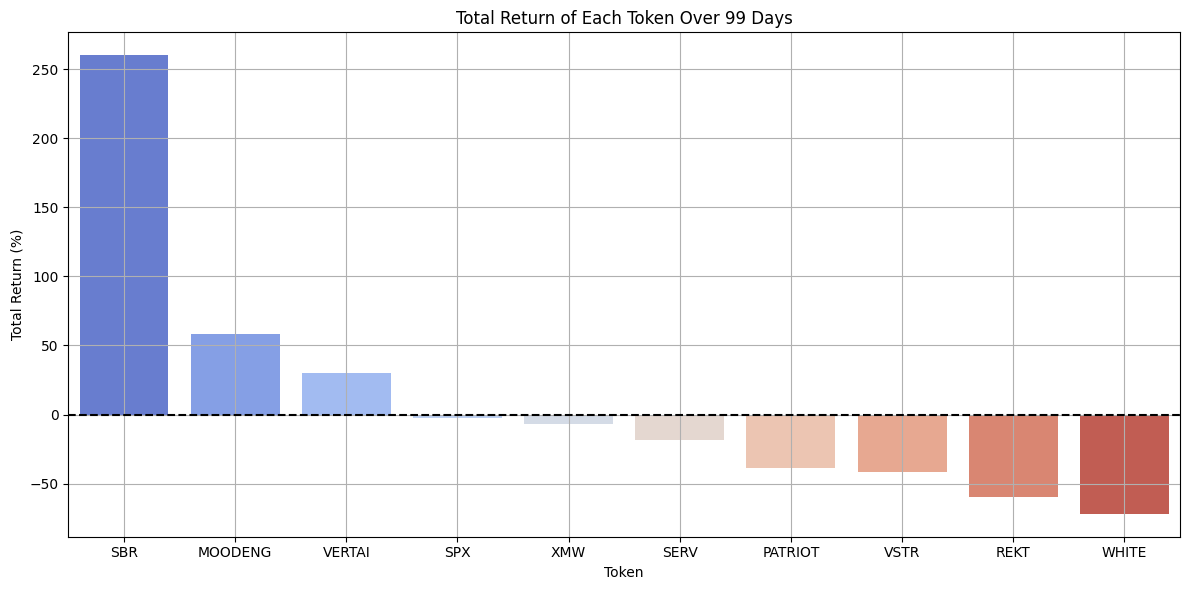

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(x='Token', y='Total Return (%)', data=pnl_df, palette='coolwarm')
plt.title('Total Return of Each Token Over 99 Days')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()